# Detectron2 Custom Training Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2!

# Install detectron2

In [1]:
# !pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.12 ; cuda:  cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-r1k5we42
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-r1k5we42


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pwd

'/content'

In [ ]:
# %cd ..

/config/workspace


In [4]:
# %cd data/Sign_language_data
!unzip data.zip; rm data.zip

Archive:  data.zip
  inflating: coco.json               
  inflating: data.yaml               
   creating: test/
   creating: test/images/
  inflating: test/images/Hello.82af5cd8-a6d1-11ec-a2fc-84a93ea18ae6.jpg  
  inflating: test/images/Hello.8b2540a6-a6d1-11ec-a828-84a93ea18ae6 - Copy.jpg  
  inflating: test/images/Hello.8b2540a6-a6d1-11ec-a828-84a93ea18ae6.jpg  
  inflating: test/images/Hello.8c5b98c8-a6d1-11ec-a905-84a93ea18ae6.jpg  
  inflating: test/images/Hello.8d922278-a6d1-11ec-9c17-84a93ea18ae6.jpg  
  inflating: test/images/IloveYou.01279dee-a6d2-11ec-a775-84a93ea18ae6.jpg  
  inflating: test/images/IloveYou.0391a1b8-a6d2-11ec-9246-84a93ea18ae6.jpg  
  inflating: test/images/IloveYou.04c7764c-a6d2-11ec-998a-84a93ea18ae6 - Copy.jpg  
  inflating: test/images/IloveYou.04c7764c-a6d2-11ec-998a-84a93ea18ae6.jpg  
  inflating: test/images/IloveYou.05fc3c80-a6d2-11ec-ba0a-84a93ea18ae6.jpg  
  inflating: test/images/No.b81769f8-a6d1-11ec-8d33-84a93ea18ae6.jpg  
  inflating: test/im

In [4]:
!ls

coco.json  data.yaml  sample_data  test  train


# Register data

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("customtrain", {}, "/content/coco.json", "/content/train/images")

In [6]:
sample_metadata = MetadataCatalog.get("customtrain")
dataset_dicts = DatasetCatalog.get("customtrain")

[11/06 15:15:59 d2.data.datasets.coco]: Loaded 120 images in COCO format from /content/coco.json


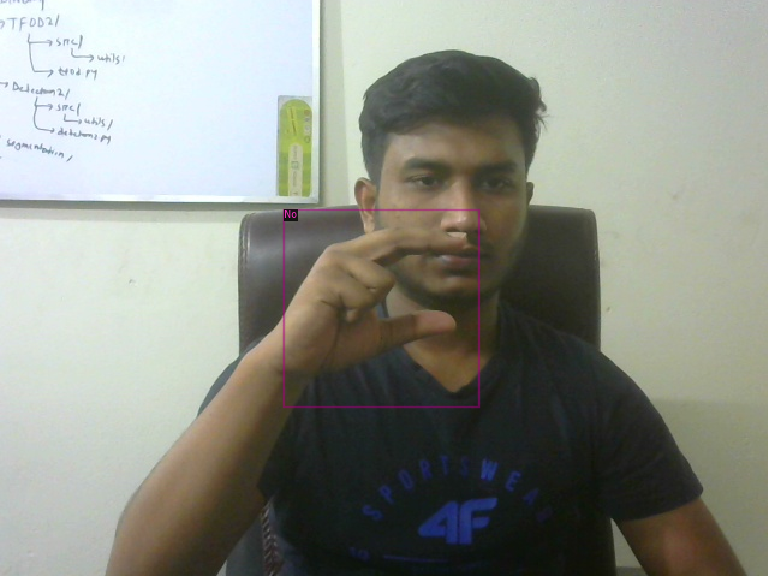

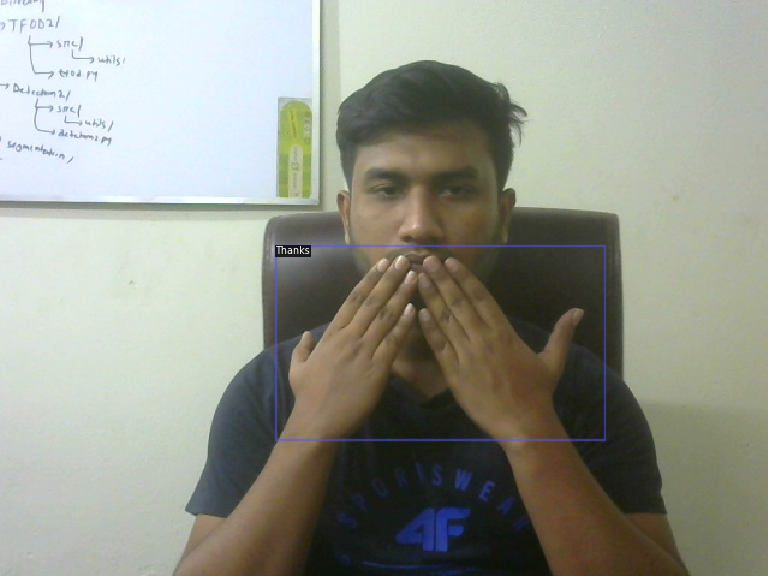

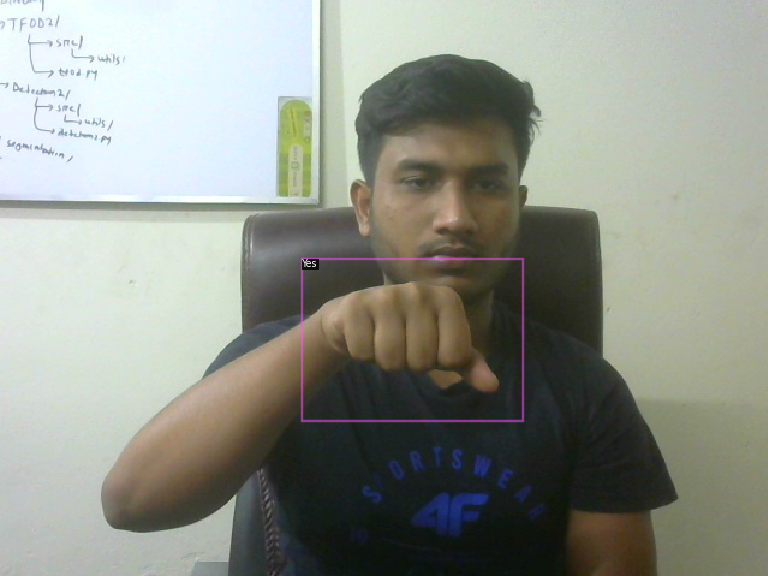

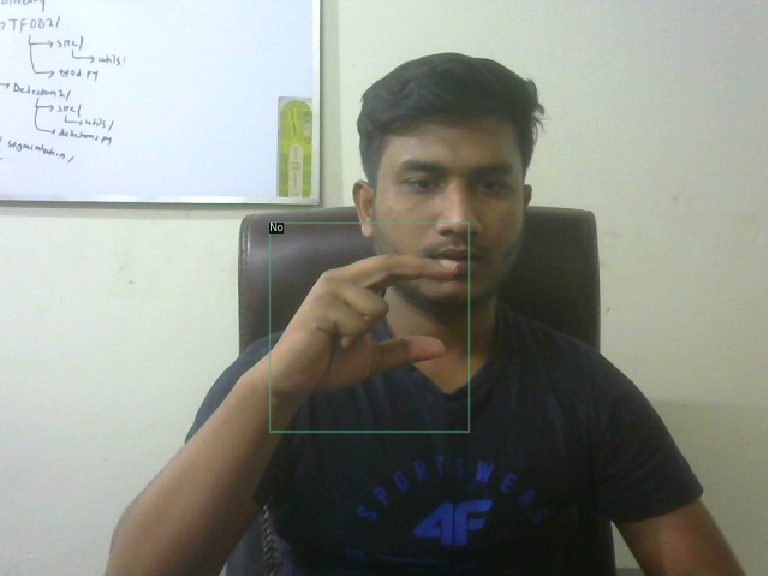

In [7]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=1.2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Training

In [10]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("customtrain",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[11/06 15:18:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("customtrain", )
predictor = DefaultPredictor(cfg)

[11/06 15:21:10 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

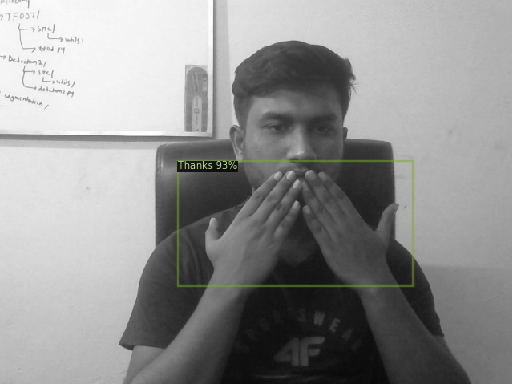

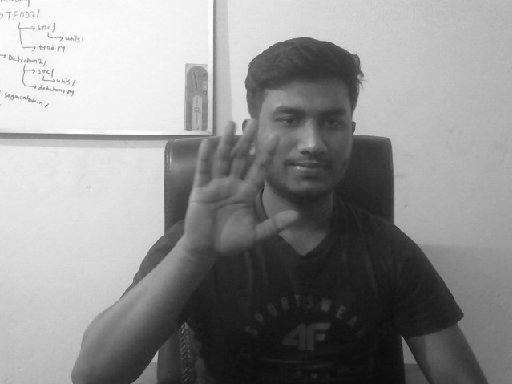

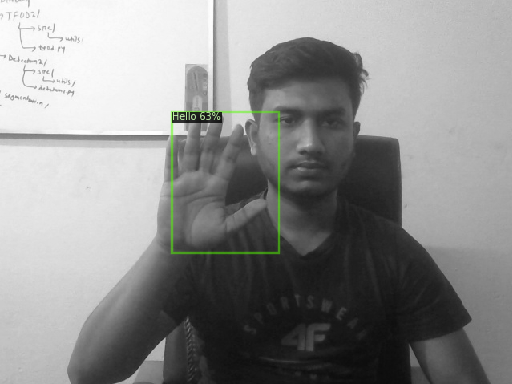

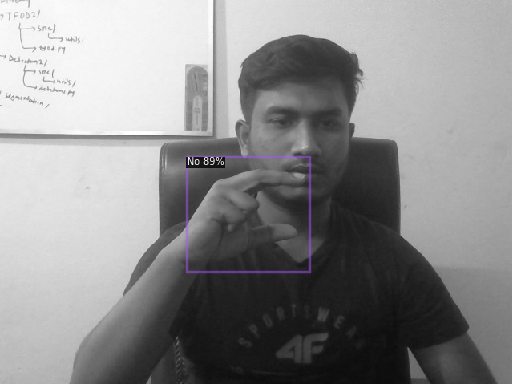

In [12]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
# %cd data_detectron2

/content/drive/MyDrive/Classes/Detectron2_detection/data_detectron2


# Evaluation

In [13]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("customtrain", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "customtrain")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[11/06 15:21:42 d2.data.datasets.coco]: Loaded 120 images in COCO format from /content/coco.json
[11/06 15:21:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/06 15:21:42 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[11/06 15:21:42 d2.data.common]: Serializing 120 elements to byte tensors and concatenating them all ...
[11/06 15:21:42 d2.data.common]: Serialized dataset takes 0.03 MiB
[11/06 15:21:42 d2.evaluation.evaluator]: Start inference on 120 batches
[11/06 15:21:43 d2.evaluation.evaluator]: Inference done 11/120. Dataloading: 0.0033 s/iter. Inference: 0.1013 s/iter. Eval: 0.0002 s/iter. Total: 0.1048 s/iter. ETA=0:00:11
[11/06 15:21:48 d2.evaluation.evaluator]: Inference done 59/120. Dataloading: 0.0025 s/iter. Inference: 0.1018 s/iter. Eval: 0.0003 s/iter. Total: 0.1047 s/iter. ETA=0:00:06
[11/06 15:21:5

### Getting the custom config file

In [14]:
pwd

'/content'

In [15]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()